In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import sys

# Número  muy muy pequeño.
epsilon = sys.float_info.epsilon

# Parte (d)
Generamos una muestra de tamaño 100 para el modelo $\textbf{AR(1)}$ $Y_n = c + \varphi Y_{n-1} + \epsilon_n$ con $c=1,\ \varphi = 0.5,\ \sigma^2 = 1$. Con estos valores tenemos que para $n\rightarrow \infty$:

$$
\begin{align}
    \mathbb{E}(Y_n) &\approx \frac{c}{1 - \varphi} = 2\\
    \mathbb{V}(Y_n) &\approx \frac{\sigma^2}{1 - \varphi^2} = 1.333
\end{align}
$$

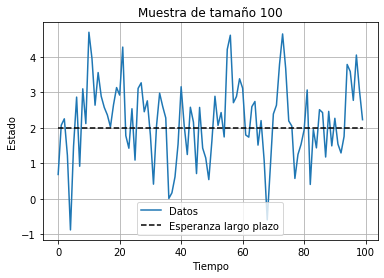

In [3]:
# Parámetros que generan las observaciones.
np.random.seed(6)
c = 1
phi = 0.5
sigmaSqr = 1
thetaReal = np.array([c, phi, sigmaSqr])

mean = c / (1 - phi)
std = sigmaSqr / (1 - phi**2)

# Generación de datos.
def genDatos(n = 100):
    c = 1
    sigmaSqr = 1
    # Genera una muestra del modelo AR(1) de tamaño n.
    eps = np.random.normal(0, sigmaSqr, n)
    Y = np.empty(n)
    Y[0] = c + eps[0]
    for i in range(1, n):
        Y[i] = c + phi * Y[i - 1] + eps[i]
    return Y 

# Visualización de los datos.
n = 100
Y = genDatos(n)
plt.title("Muestra de tamaño "  + str(n))
plt.xlabel('Tiempo')
plt.ylabel('Estado')
plt.plot(Y, label='Datos')
plt.plot(np.ones(n) * mean, '--k', label='Esperanza largo plazo')
plt.legend(loc='lower center')
plt.grid()
plt.show()

En la siguiente celda de código haremos unos calculos previos para encontrar un $\textit{initial guess}$ para el vector $[c, \varphi, \sigma^2]$. Para esto, generaremos $N = 150$ realizaciones $iid$ de la variable $Y_n$, para poder aproximar:

$$
\begin{align}
    \mathbb{E}(Y_n) &\approx \frac{1}{N} \sum_{i=1}^{N}x_i\\
    \mathbb{V}(Y_n) &\approx \frac{1}{N - 1} \sum_{i=1}^{N} (x_i - \bar{x})^2
\end{align}
$$

Con $(x_i)_{i=0}^{N}$ las realizaciones. Con esto y las aproximaciones a largo plazo obtenemos dos ecuaciones:

$$
\begin{align}
    \frac{1}{N} \sum_{i=1}^{N}x_i \approx \frac{c}{1 - \varphi}\\
    \frac{1}{N - 1} \sum_{i=1}^{N} (x_i - \bar{x})^2 \approx \frac{\sigma^2}{1 - \varphi^2}
\end{align}
$$

y tres incógnitas $[c, \varphi, \sigma^2]$. Es decir, tenemos que si o si proponer una aproximación inicial para alguno de los parámetros. Escogemos fijar $\varphi = 0.7$ pues es el parámetro que está confinado a un intervalo más pequeño. En la celda $Out$ de la siguiente celda, se exponen las aproximaciones iniciales.

In [4]:
# Seteamos una seed diferente solo para esta celda pues es independiente de las otras.
np.random.seed(5)

# Trataremos de buscar aproximaciones iniciales mas o menos buenas para optimizar.
# Generaremos N = 50 aproximaciones de Y_n para n = 100, se hará un doble for.

# Realizaciones del proceso.
N = 150

# Largo del proceso.
n = 100

# Guardará N realizaciones de Y_n.
A = []

# Generación
for i in range(N):
    A.append(genDatos(n)[n - 1])

meanAprox = np.mean(A)
theta = [0, 0, 0]
theta[1] = 0.7
theta[0] = meanAprox * (1 - theta[1])
theta[2] = sum((1 / (N - 1))*(A[i] - meanAprox)**2 for i in range(N)) * (1 - theta[1]**2)

tab = pd.DataFrame()
tab['Parámetros'] = ['c', 'phi', 'sigmaSqr']
tab['Aproximación inicial'] = theta
print(tab)

  Parámetros  Aproximación inicial
0          c              0.651260
1        phi              0.700000
2   sigmaSqr              0.663363


Maximizamos la versimilitud de los datos $\left\{ y_1,...,y_n\right\}$ que resulta ser:

$$
p(y_1,...,y_n|c, \varphi, \sigma^2) = \frac{1}{(2\pi \sigma^2)^{n/2}}exp(-\frac{1}{2\sigma^2}\sum_{i=1}^{n}(y_i -c-\varphi     y_{i-1})^2)
$$

Dado que queremos maximizar este valor sobre $\theta \in \mathbb{R} \times \mathbb{R} \times \mathbb{R}_{+}$ , conviene usar la log verosimilitud $l(\theta)$:

$$
\begin{align}
    l(c, \varphi, \sigma^2) = -\frac{n}{2}log(2\pi \sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^{n}(y_i - c -\varphi y_{i-1})^2
\end{align}
$$

<ipython-input-5-94fb34ff06d9>:23: RuntimeWarning: invalid value encountered in log
  minusLogVer = lambda theta: (n / 2) * np.log(2 * np.pi * theta[2]) + (1 / (2 * theta[2])) * sum((Y[i] - theta[0] - theta[1]*Y[i - 1])**2


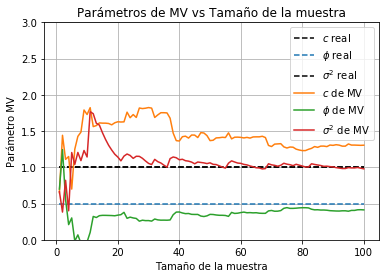

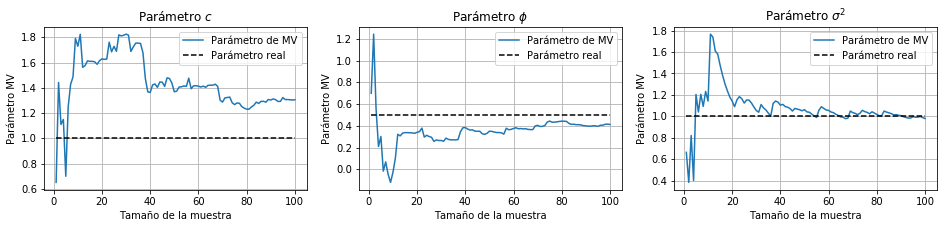

    Tamaño de la muestra         c       phi   sigma^2
0                     90  1.303110  0.399576  1.005516
1                     91  1.311945  0.397376  0.995950
2                     92  1.306130  0.396651  0.989960
3                     93  1.292098  0.400033  0.983449
4                     94  1.292098  0.400033  0.983449
5                     95  1.322443  0.394469  0.996072
6                     96  1.306806  0.405522  0.991658
7                     97  1.306806  0.405522  0.991658
8                     98  1.305058  0.414090  0.997787
9                     99  1.303313  0.415231  0.987763
10                   100  1.305202  0.412798  0.979032


In [5]:
# Seteamos la seed.
np.random.seed(6)

def maxVer():
    # Calcula y plotea parámetros de máxima verosimilitud variando la cantidad de muestras.
    
    # Se inicializan las estimaciones.
    arrC = [theta[0]]
    arrPhi = [theta[1]]
    arrSigmaSqr = [theta[2]]
    
    # Generamos muestra de tamaño N = 10000.
    N = 100
    Y = genDatos(N)
    step = 1
    x = np.arange(step, N + step, step)
 
    
    for i in range(len(x)):
        #n = 100
        n = x[i]
        #Definimos la función -logVerosimilitud.
        minusLogVer = lambda theta: (n / 2) * np.log(2 * np.pi * theta[2]) + (1 / (2 * theta[2])) * sum((Y[i] - theta[0] - theta[1]*Y[i - 1])**2 
                                                                                   for i in range(1, n)) 
        #Minimizamos
        bound = ((None, None), (1 + epsilon, 1 - epsilon), (epsilon, None))
        opti = minimize(minusLogVer, [arrC[i], arrPhi[i], arrSigmaSqr[i]], method='L-BFGS-B')
        arrC.append(opti.x[0])
        arrPhi.append(opti.x[1])
        arrSigmaSqr.append(opti.x[2])
    
    # Plot todo junto para informe.
    
    plt.plot(x, c * np.ones(len(x)), '--k', label='$c$ real')
    plt.plot(x, phi * np.ones(len(x)), '--', label='$\phi$ real')
    plt.plot(x, c * np.ones(len(x)), '--k', label='$\sigma^2$ real')
    plt.plot(x, arrC[1:], label='$c$ de MV')
    plt.plot(x, arrPhi[1:], label='$\phi$ de MV')
    plt.plot(x, arrSigmaSqr[1:], label='$\sigma^2$ de MV')

    plt.title('Parámetros de MV vs Tamaño de la muestra')
    plt.xlabel('Tamaño de la muestra')
    plt.ylabel('Parámetro MV')
    plt.ylim(0, 3)
    plt.grid()
    plt.legend()
    plt.show()

    # Plot por separado.
    
    fig, ax = plt.subplots(1, 3, figsize=(16, 3))

    # c:
    ax[0].plot(x, arrC[1:], label='Parámetro de MV')
    ax[0].plot(x, c * np.ones(len(x)), '--k', label='Parámetro real')
    ax[0].set_title('Parámetro $c$')
    ax[0].set_xlabel('Tamaño de la muestra')
    ax[0].set_ylabel('Parámetro MV')
    ax[0].grid()
    ax[0].legend()
    # phi: 
    ax[1].plot(x, arrPhi[1:], label='Parámetro de MV')
    ax[1].plot(x, phi * np.ones(len(x)), '--k', label='Parámetro real')
    ax[1].set_title('Parámetro $\phi$')
    ax[1].set_xlabel('Tamaño de la muestra')
    ax[1].set_ylabel('Parámetro MV')
    ax[1].grid()
    ax[1].legend()
    # sigma^2:
    ax[2].plot(x, arrSigmaSqr[1:], label='Parámetro de MV')
    ax[2].plot(x, sigmaSqr * np.ones(len(x)), '--k', label='Parámetro real')
    ax[2].set_title('Parámetro $\sigma^2$')
    ax[2].set_xlabel('Tamaño de la muestra')
    ax[2].set_ylabel('Parámetro MV')
    ax[2].grid()
    ax[2].legend()
    plt.show()
    
    # Guardamos en un DataFrame.
    df = pd.DataFrame()
    df['Tamaño de la muestra'] = x[89:]
    df['c'] = arrC[90:]
    df['phi'] = arrPhi[90:]
    df['sigma^2'] = arrSigmaSqr[90:]
    print(df)
    
    
    
maxVer()

# Parte (e)
Proponemos un prior uniforme en $A := [c_1,c_2] \times (\varphi_1, \varphi_2) \times [\sigma^2_1, \sigma^2_1]$, es decir:

$$
p(c, \varphi, \sigma^2) = \frac{1}{(c_2 - c_1)(\varphi_2 - \varphi_1)(\sigma^2_2 - \sigma^2_1)}\mathbb{1}_{A}
$$

Luego la densidad a posteriori será proporcional a la verosimilitud:

$$
\begin{align*}
    p(c, \varphi, \sigma^2|\vec{y}_n) &\propto \frac{p(\vec{y}_n|c, \varphi, \sigma^2)}{(c_2 - c_1)(\varphi_2 - \varphi_1)(\sigma^2_2 - \sigma^2_1)}\\
    &\propto p(\vec{y}_n|c, \varphi, \sigma^2)
\end{align*}
$$
Esto no agrega nueva información para maximizar, puesto que sólo son constantes. Es decir, el MAP para una a priori uniforme será el mismo que el MV. 

In [7]:
#seteamos la seed.
np.random.seed(6)

# Prior uniforme:
c1 = -3
c2 = 3
phi1 = -1
phi2 = 1
sigmaSqr1 = 1 / 2
sigmaSqr2 = 2

def MAP1():    
    # Arreglo que guardará los parámetros.
    arr = [np.array(theta)]
    
    # Generamos muestra de tamaño N = 10000.
    step = 1
    N = 100
    Y = genDatos(N)
    x = np.arange(step, N + 1, step)
    
    for i in range(len(x)):
        n = x[i]
        #Definimos la función -log(p(theta|D)).
        minusLogVer = lambda theta: (n / 2) * np.log(2 * np.pi * theta[2]) + (1 / (2 * theta[2])) * sum((Y[i] - theta[0] - theta[1]*Y[i - 1])**2 for i in range(1, n)) - np.log((c2 - c1) * (phi2 - phi1) * (sigmaSqr2 - sigmaSqr1)) 
        #Minimizamos
        bound = ((c1, c2), (phi1, phi2), (sigmaSqr1, sigmaSqr2))
        opti = minimize(minusLogVer, arr[i], method='L-BFGS-B', bounds=bound)
        arr.append(np.array(opti.x))
MAP1()

# Parte (f)
Asumiremos que tenemos un valor más probable dentro de cada intervalo. Esta nueva información se traducirá en que nuestras nuevas prior serán densidades $Beta$ desplazadas al intervalo correspondiente y parámetros $\alpha$ y $\beta$ de forma que la esperanza de la nueva variable sea justamente el valor al cual se cree más cercano el parámetro. Este procedimiento se explica en el informe, el parámetro que queda libre lo fijaremos en b = 10.

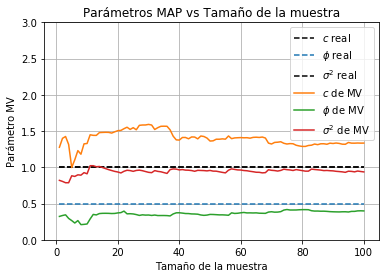

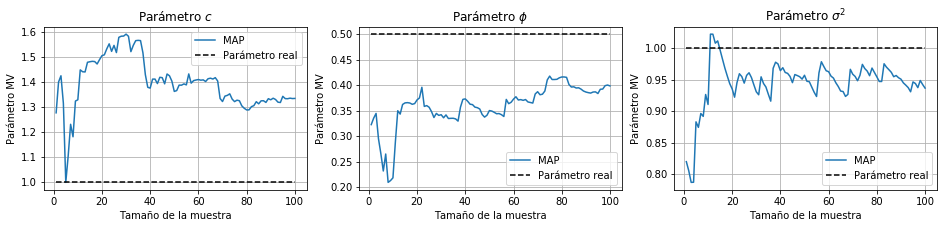

    Tamaño de la muestra         c       phi   sigma^2
0                     90  1.328867  0.386503  0.950860
1                     91  1.335242  0.385284  0.944986
2                     92  1.330016  0.384422  0.941412
3                     93  1.319300  0.386461  0.937477
4                     94  1.317985  0.386809  0.930852
5                     95  1.342798  0.383552  0.946469
6                     96  1.333589  0.391907  0.943968
7                     97  1.333150  0.392298  0.937415
8                     98  1.335395  0.398949  0.948736
9                     99  1.333784  0.400210  0.942318
10                   100  1.334299  0.398473  0.936695


In [8]:
# Seteamos la seed
np.random.seed(6)

# Eleguimos valores dados por el/la experto/a. 
cProb = 1.2 #thetaReal[0] #2
amp0 = (cProb - c1) / (c2 - cProb)
phiProb = 0.3 #thetaReal[1] #0.3
amp1 = (phiProb - phi1) / (phi2 - phiProb)
sigmaSqrProv = 0.9 #thetaReal[2] #1.7
amp2 = (sigmaSqrProv - sigmaSqr1) / (sigmaSqr2 - sigmaSqrProv)

# Fijamos un parámetro de la beta.
b = 10

def betaDesplazada(x, alpha, beta, a, b):
    # Retorna densidad de Z = a + (b - a)*X evaluada en x donde X es Beta(alpha, beta)
    delta = b - a
    x = (x - a) / delta
    return stats.beta.pdf(x, alpha, beta) * (1 / delta)

def logPrior2(theta):
    # Retorna valor proporcional log(p(theta)). Con prior Beta desplazada.
    c, phi, sigmaSqr = theta[0], theta[1], theta[2]
    if c1 < c < c2 and phi1 < phi < phi2 and sigmaSqr1 < sigmaSqr < sigmaSqr2:
        return (b*amp0 - 1)*np.log(c - c1) + (b - 1)*np.log(c2 - c) + (b*amp1 - 1)*np.log(phi - phi1) + (b - 1)*np.log(phi2 - phi) + (b*amp2 - 1)*np.log(sigmaSqr - sigmaSqr1) + (b - 1)*np.log(sigmaSqr2 - sigmaSqr)
    else:
        return 0



def MAP2():    
    # Arreglos que guardarán los parámetros.
    arrC = [theta[0]]
    arrPhi = [theta[1]]
    arrSigmaSqr = [theta[2]]
    
    # Generamos muestra de tamaño N.
    step = 1
    N = 100
    Y = genDatos(N)
    x = np.arange(step, N + step, step)

    for i in range(len(x)):
        n = x[i]
        #Definimos la función -log(p(theta|D)).
        minusLogVer = lambda theta: (n / 2) * np.log(2 * np.pi * theta[2]) + (1 / (2 * theta[2])) * sum((Y[i] - theta[0] - theta[1]*Y[i - 1])**2 for i in range(1, n)) - logPrior2(theta)
        #Minimizamos
        bound = ((c1, c2), (phi1, phi2), (sigmaSqr1, sigmaSqr2))
        opti = minimize(minusLogVer, [arrC[i], arrPhi[i], arrSigmaSqr[i]], method='L-BFGS-B', bounds=bound)
        arrC.append(opti.x[0])
        arrPhi.append(opti.x[1])
        arrSigmaSqr.append(opti.x[2])

    # Plot todo junto para informe.
    
    plt.plot(x, c * np.ones(len(x)), '--k', label='$c$ real')
    plt.plot(x, phi * np.ones(len(x)), '--', label='$\phi$ real')
    plt.plot(x, c * np.ones(len(x)), '--k', label='$\sigma^2$ real')
    plt.plot(x, arrC[1:], label='$c$ de MV')
    plt.plot(x, arrPhi[1:], label='$\phi$ de MV')
    plt.plot(x, arrSigmaSqr[1:], label='$\sigma^2$ de MV')

    plt.title('Parámetros MAP vs Tamaño de la muestra')
    plt.xlabel('Tamaño de la muestra')
    plt.ylabel('Parámetro MV')
    plt.ylim(0, 3)
    plt.grid()
    plt.legend()
    plt.show()

    # Plot por separado.
    
    fig, ax = plt.subplots(1, 3, figsize=(16, 3))

    # c:
    ax[0].plot(x, arrC[1:], label='MAP')
    ax[0].plot(x, c * np.ones(len(x)), '--k', label='Parámetro real')
    ax[0].set_title('Parámetro $c$')
    ax[0].set_xlabel('Tamaño de la muestra')
    ax[0].set_ylabel('Parámetro MV')
    ax[0].grid()
    ax[0].legend()
    # phi: 
    ax[1].plot(x, arrPhi[1:], label='MAP')
    ax[1].plot(x, phi * np.ones(len(x)), '--k', label='Parámetro real')
    ax[1].set_title('Parámetro $\phi$')
    ax[1].set_xlabel('Tamaño de la muestra')
    ax[1].set_ylabel('Parámetro MV')
    ax[1].grid()
    ax[1].legend()
    # sigma^2:
    ax[2].plot(x, arrSigmaSqr[1:], label='MAP')
    ax[2].plot(x, sigmaSqr * np.ones(len(x)), '--k', label='Parámetro real')
    ax[2].set_title('Parámetro $\sigma^2$')
    ax[2].set_xlabel('Tamaño de la muestra')
    ax[2].set_ylabel('Parámetro MV')
    ax[2].grid()
    ax[2].legend()
    plt.show()
    
    # Guardamos en un DataFrame.
    df = pd.DataFrame()
    df['Tamaño de la muestra'] = x[89:]
    df['c'] = arrC[90:]
    df['phi'] = arrPhi[90:]
    df['sigma^2'] = arrSigmaSqr[90:]
    print(df)

MAP2()


# Parte (f)
Aquí mostramos los errores

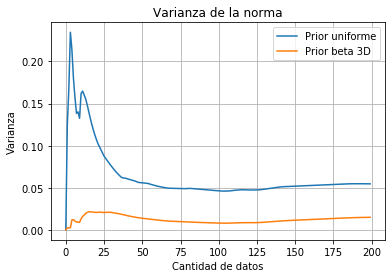

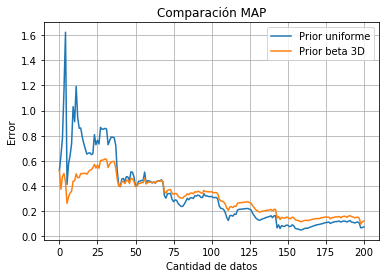

In [66]:
# Seteamos la seed
np.random.seed(6)

# Eleguimos valores dados por el/la experto/a. 
cProb = 1.2 # 1
amp0 = (cProb - c1) / (c2 - cProb)
phiProb = 0.3#0.5 
amp1 = (phiProb - phi1) / (phi2 - phiProb)
sigmaSqrProv = 0.9 #1
amp2 = (sigmaSqrProv - sigmaSqr1) / (sigmaSqr2 - sigmaSqrProv)

# Fijamos un parámetro de la beta.
b = 10

def logPrior2(theta):
    # Retorna valor proporcional log(p(theta)). Con prior Beta desplazada.
    c, phi, sigmaSqr = theta[0], theta[1], theta[2]
    if c1 < c < c2 and phi1 < phi < phi2 and sigmaSqr1 < sigmaSqr < sigmaSqr2:
        return (b*amp0 - 1)*np.log(c - c1) + (b - 1)*np.log(c2 - c) + (b*amp1 - 1)*np.log(phi - phi1) + (b - 1)*np.log(phi2 - phi) + (b*amp2 - 1)*np.log(sigmaSqr - sigmaSqr1) + (b - 1)*np.log(sigmaSqr2 - sigmaSqr)
    else:
        return 0

def MAP():   

    # Generamos muestra de tamaño N = 100.
    step = 1
    N = 200
    Y = genDatos(N)
    x = np.arange(step, N + step, step)
       
    # Arreglo que guardará los parámetros. Se inicializa con la primera estimación.
    arr = [[None] * (int(N/step) + 1), [None] * (int(N/step) + 1)]
    arr[0][0] = theta
    arr[1][0] = theta
    
    # Vector de errores.
    e = np.zeros((2, int(N/step) + 1))
    e[0,0] = np.linalg.norm(np.array(arr[0][0]) - thetaReal) 
    e[1,0] = e[0,0]
    
    # Vector de varianzas.
    var0 = []
    var1 = []
    
    # Varianzas
    aux0 = []
    var0 = []
    aux1 = []
    var1 = []
    
    for i in range(len(x)):
        
        n = x[i]
        
        # Prior uniforme.
        minusLogVer0 = lambda theta: (n / 2) * np.log(2 * np.pi * theta[2]) + (1 / (2 * theta[2])) * sum((Y[i] - theta[0] - theta[1]*Y[i - 1])**2 for i in range(1, n)) - np.log((c2 - c1) * (phi2 - phi1) * (sigmaSqr2 - sigmaSqr1)) 
        
        # Prior Beta 3D.
        minusLogVer1 = lambda theta: (n / 2) * np.log(2 * np.pi * theta[2]) + (1 / (2 * theta[2])) * sum((Y[i] - theta[0] - theta[1]*Y[i - 1])**2 for i in range(1, n)) - logPrior2(theta)        
        
        #Minimizamos
        bound = ((c1, c2), (phi1, phi2), (sigmaSqr1, sigmaSqr2))
        opti0 = minimize(minusLogVer0, arr[0][i], method='L-BFGS-B', bounds=bound)
        opti1 = minimize(minusLogVer1, arr[1][i], method='L-BFGS-B', bounds=bound)
        e[0, i + 1] = np.linalg.norm(np.array(opti0.x) - thetaReal)
        e[1, i + 1] = np.linalg.norm(np.array(opti1.x) - thetaReal)
        
        arr[0][i + 1] = opti0.x
        arr[1][i + 1] = opti1.x
        
        # Varianzas
        aux0.append(np.linalg.norm(opti0.x))
        var0.append(np.var(aux0))
        aux1.append(np.linalg.norm(opti1.x))
        var1.append(np.var(aux1))
        
    plt.plot(var0, label='Prior uniforme')
    plt.plot(var1, label='Prior beta 3D')
    plt.title('Varianza de la norma')
    plt.ylabel('Varianza')
    plt.xlabel('Cantidad de datos')
    plt.legend()
    plt.grid()
    plt.show()
        
        

    
    # Plot errores
    plt.plot(np.arange(0, N + 1, step), e[0,:], label='Prior uniforme')
    plt.plot(np.arange(0, N + 1, step), e[1,:], label='Prior beta 3D')
    plt.title('Comparación MAP')
    plt.xlabel('Cantidad de datos')
    plt.ylabel('Error')
    plt.legend()
    plt.grid()
    plt.show()
    
MAP()